# Library calls

In [1]:
import pandas as pd 
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as  plt 
import cv2
import tensorflow as tf 
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten,InputLayer,Input
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import ResNet152V2,DenseNet121,InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalseNegatives,FalsePositives
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score

# Load the dataset

In [2]:
directory = 'C:/Users/Yadav Ji/Desktop/BrainAI_framework/BrainAI_Framework/datasets/brain_tumer_dataset/brain_tumor_dataset'

In [3]:
class_names = ['no','yes']

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 253 files belonging to 2 classes.


# Data preprocessing 

## splits

In [5]:
def splits(dataset,Train_ratio,Val_ratio,Test_ratio):
    
    data_size = len(dataset)
    
    train_dataset = dataset.take(int(data_size*Train_ratio))
    
    val_split_set = dataset.skip(int(data_size*Train_ratio))
    
    val_dataset = val_split_set.take((int(data_size*Val_ratio)))
    
    test_dataset = val_split_set.skip(int(data_size*Test_ratio))
    return train_dataset,val_dataset,test_dataset 

Train_ratio = 0.80 
Val_ratio = .10
Test_ratio = 0.10
train_dataset,val_dataset,test_dataset  = splits(dataset,Train_ratio,Val_ratio,Test_ratio)

print("The length of the train_dataset is  : ",len(train_dataset))
print('The length of the val_dataset is  : ',len(val_dataset))
print('The length of the test_dataset is  : ',len(test_dataset))
      

The length of the train_dataset is  :  202
The length of the val_dataset is  :  25
The length of the test_dataset is  :  26


## visualize some image

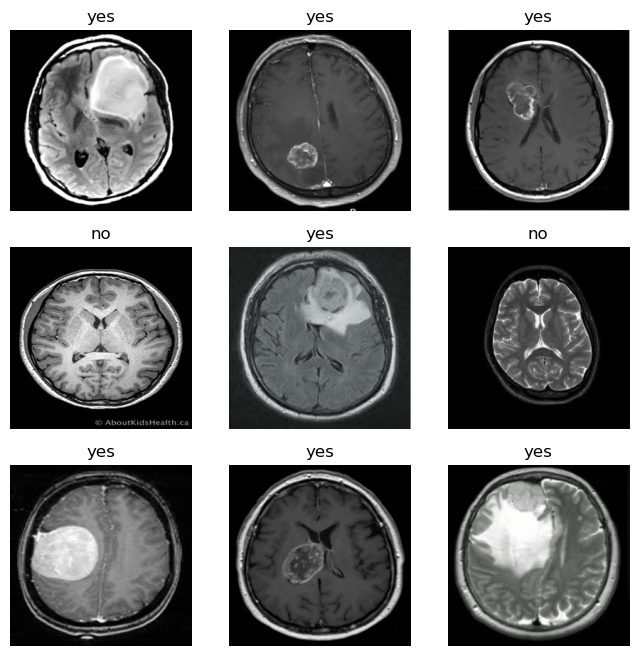

In [6]:
plt.figure(figsize=(8,8))
for i,(image,label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(class_names[label])
    plt.axis('off')

## Dataset prepraration

In [7]:
#  resize and rescaling

def resize_rescaling(image,label):
    
    return tf.image.resize(image,(224,224))/255,label

In [8]:
train_dataset = (
             train_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(10)
            .prefetch(tf.data.AUTOTUNE)
)

In [9]:
val_dataset = (
             val_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(3)
            .prefetch(tf.data.AUTOTUNE)
)

In [10]:
test_dataset = (
             test_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
)

# Create  a model 

In [11]:
Lenet_model = tf.keras.Sequential([
    InputLayer(shape=(224,224,3)),
    
    Conv2D(filters=32, kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=2),

    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=1),
    
    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    
    BatchNormalization(),

    MaxPooling2D(pool_size=3,strides=1),
    Dropout(0.2),
    

    Flatten(),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    
    Dense(1,activation='sigmoid')
],name='Lenet_model')
Lenet_model.summary()

Model: "Lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,377 (896.00 KB)

 Trainable params: 228,929 (894.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
Lenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.001),
                   metrics = ['accuracy'])

In [13]:
checkpoint_path = "/kaggle/working/best_model.keras"  # Change the extension to .h5
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Corrected parameter name and file extension
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30, 
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [14]:
history = Lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=30,
                          verbose=1,
                          callbacks = [checkpoint_callback,
                                      early_stopping ]
                       
                         )

Epoch 1/30


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7244 - loss: 1.2825
Epoch 1: val_loss improved from inf to 1.41247, saving model to /kaggle/working/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - accuracy: 0.7225 - loss: 1.2840 - val_accuracy: 0.4800 - val_loss: 1.4125
Epoch 2/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7440 - loss: 1.1949
Epoch 2: val_loss improved from 1.41247 to 1.35072, saving model to /kaggle/working/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7443 - loss: 1.1958 - val_accuracy: 0.5600 - val_loss: 1.3507
Epoch 3/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7821 - loss: 1.1391
Epoch 3: val_loss did not improve from 1.35072
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.7803 - loss: 1.1419 - val_accuracy: 0.5200 - val_loss: 1.4541
Epoch 4/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7729 - loss: 1.1994
Epoch 4: val_loss improved from 1.35072 to 1.32632, saving model to /k

## Evaluate the model 

In [15]:
def evaluate_model(model,dataset):
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    accuracy = model.history.history['accuracy']
    val_accuracy = model.history.history['val_accuracy']
    
    plt.figure(figsize=(14,12))
    
    # Plot model loss 
    plt.subplot(2,2,1)
  
    plt.plot(val_loss)
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['train_loss','val_loss'])
    plt.grid()

    # Plot model accuracy
    plt.subplot(2,2,2)
   
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.grid()
    
    # confusion matrix
    plt.subplot(2,2,3)
    
    img = []
    labels = []
    for x,y in dataset:
        img.append(x)
        labels.append(y)
    true_label = np.array(labels).flatten()
    predicted = model.predict(np.array(img)[:,0,...])[:,0]
    
    threshold = 0.5

    cm = confusion_matrix(true_label, predicted > threshold)
   
  

    sns.heatmap(cm, annot=True,cmap='Blues',xticklabels=['NO','YES'],yticklabels=['NO','YES'])
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Plot roc curve
    plt.subplot(2,2,4)

    fp, tp, thresholds = roc_curve(true_label, predicted)
    roc_auc = roc_auc_score(true_label,predicted)
    plt.plot(fp,tp, color='blue',  label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")

    plt.grid()

    skip = 2

    for i in range(0, len(thresholds), skip):
      plt.text(fp[i], tp[i], thresholds[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


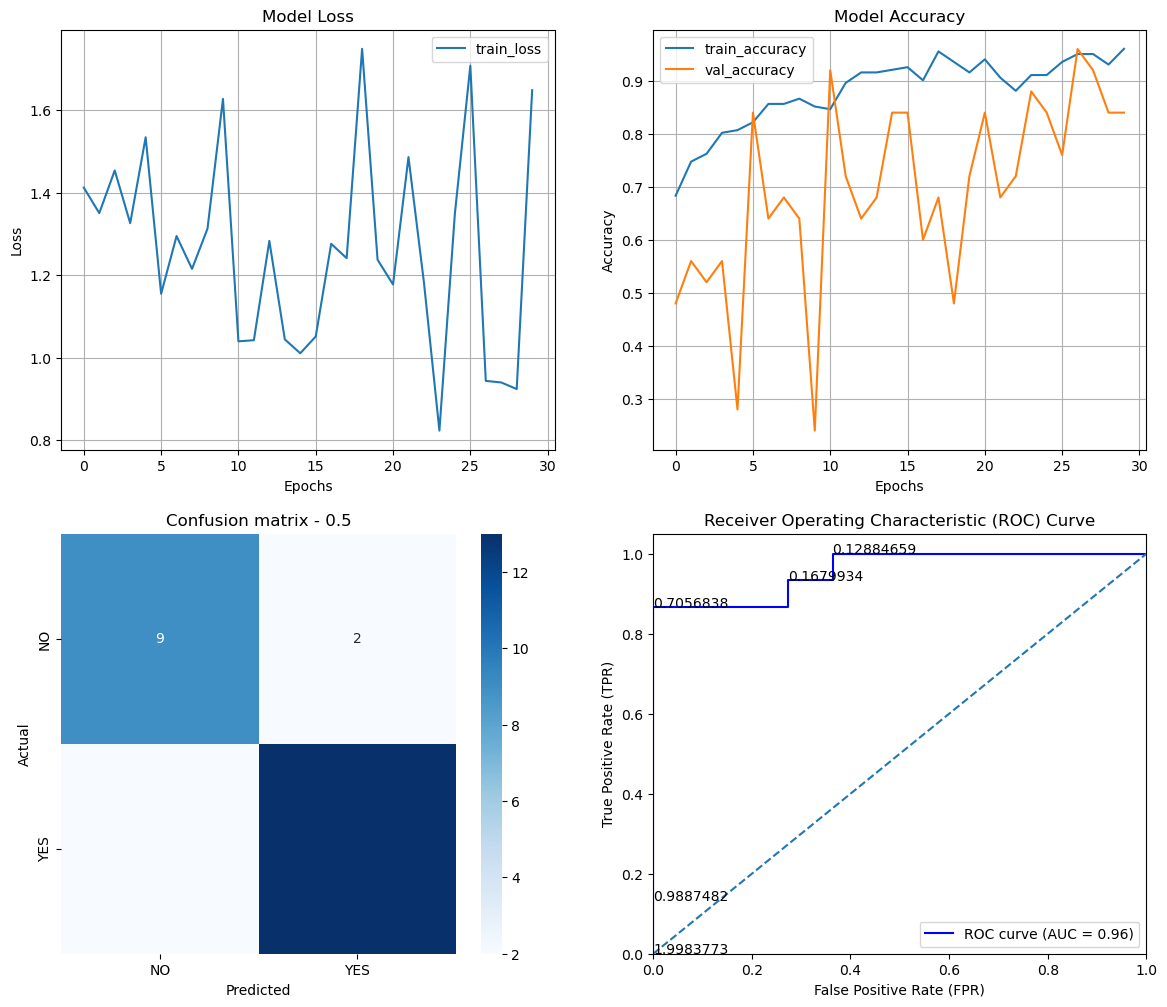

In [16]:
evaluate_model(Lenet_model,test_dataset)

In [17]:
test_evaluate = Lenet_model.evaluate(test_dataset)
test_evaluate

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8109 - loss: 0.9642


[1.0999629497528076, 0.7692307829856873]

In [18]:
val_evaluate = Lenet_model.evaluate(val_dataset)
val_evaluate

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8365 - loss: 0.9577


[0.9338420629501343, 0.8399999737739563]

# Test the a model 

## single prediction

In [19]:
def Tumor_or_Not(x):
    if x<.5:
        return str('no')
    else:
        return str('yes')

In [20]:
image = cv2.resize(cv2.imread('C:/Users/Yadav Ji/Desktop/BrainAI_framework/BrainAI_Framework/datasets/brain_tumer_dataset/no/3 no.jpg'),(224,224))
im   = tf.expand_dims(image,axis=0)
pred = Lenet_model.predict(im)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
yes


## multiple prediction with visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


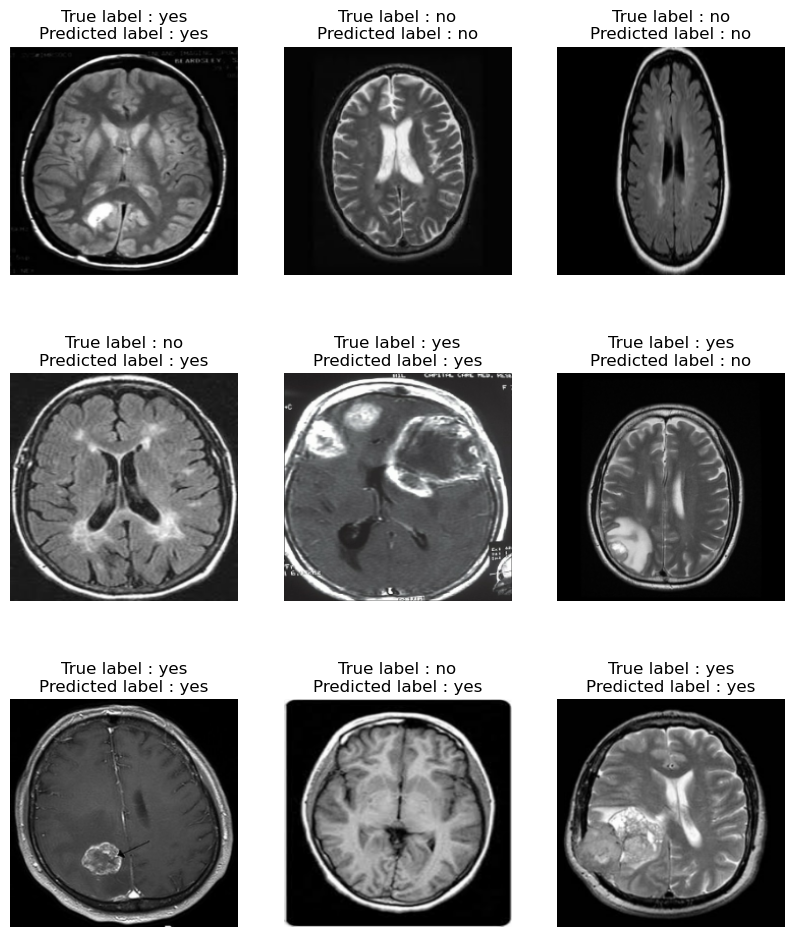

In [21]:
plt.figure(figsize=(10,12))
for i,(image,label) in  enumerate(test_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title('True label : '+class_names[label[0]]+"\n"+'Predicted label : '+
             Tumor_or_Not(Lenet_model.predict(tf.expand_dims(image[0],axis=0))[0][0]))
    plt.axis('off')

# Save and load the model 

In [23]:
import torch
import os
import torch.nn as nn

# Define the model (Make sure this class is the same as the one used for training)
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 64 * 64, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

# Ensure the models directory exists
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# Initialize model
model = TumorClassifier()

# Save only the state_dict (recommended)
model_filename = "Lenet_model.pth"
model_filepath = os.path.join(models_dir, model_filename)
torch.save(model.state_dict(), model_filepath)

print(f"Model saved to: {model_filepath}")


Model saved to: models\Lenet_model.pth


In [24]:
model = TumorClassifier()  
model.load_state_dict(torch.load(model_filepath))
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")


Model loaded successfully!


In [27]:
# test our svae model
image = cv2.resize(cv2.imread('archive/yes/Y1.jpg'),(224,224))
im   = tf.expand_dims(image,axis=0)
pred = load_lenet.predict(im)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
yes
